# HOMEWORK 02

## Exercise 1

Consider the following events:

- $A$ = "it is sick"
- $A^{c}$ = "it is healty"
- $B$ = "it is positive"
- $B^{c}$ = "it is negative"

From the assignment we can say that:

- $P(B | A^{c}) = P($"false positive"$) = 0.03$
- $P(B^{c} | A^{c}) = P($"true negative"$) = 0.97$
- $P(B | A) = P($"true positive"$) = 0.98$
- $P(B^{c} | A) = P($"false positive"$) = 0.02$

Moreover, we know that one half percent of the population contracted the disease and it means:

- $P(A) = 0.005$;       $P(A^{c}) = 0.995$

In the end we can say that Luca is positive to the test with the following law of total probability:

$P(B) = P(B | A^{c}) \cdot P(A^{c}) + P(B | A) \cdot P(A) = 0.035$

If we suppose that Luca is positive to the test, the probability that he has contracted the disease came from the Bayes Theorem:

$P(A | B) = \frac{P(B|A) \cdot P(A)}{P(B)} = \frac{0.98 \cdot 0.005}{0.035} = 0.14$

## Exercise 2

F_{X}(x) = Pr(X<=x) = 0.8472857142857143


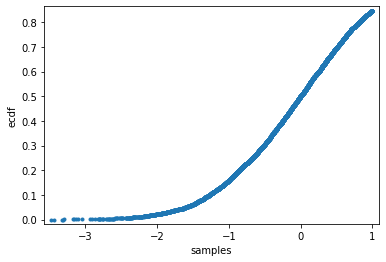

In [2]:
import torch
import pyro
import numpy as np
import pyro.distributions as dist
import matplotlib.pyplot as plt


pyro.set_rng_seed(1)
distr = dist.Normal(0, 1)
x = torch.tensor(1)

cdf = ecdf(distr, x)
print("F_{X}(x) = Pr(X<=x) =", cdf)

In [1]:
def ecdf(dist, x):
    
    """
    This function allows to compute the cdf.
    
    Parameters
    ----------
    dist: pyro.distributions
        The distribution of a r.v.
    x   : torch.tensor
        The value for which compute the cdf
        
    Returns
    -------
    list's item
        Pr(X <= x)
    """
    
    # generate samples
    sample_size = 7000 # default size
    samples = [pyro.sample("n",dist) for i in range(sample_size)]
    samples.sort()  
    
    y = np.arange(1, len(samples) + 1) / len(samples)
    
    # consider just a samples sub-set and a y sub-set
    set_x = []
    for i in samples:
        if i.item() <= x.item():
            set_x.append(i)
        else:
            break
    
    set_y = [y[i] for i in range(len(set_x))]
    
    # plot
    _ = plt.plot(set_x, set_y, marker=".", linestyle="none")
    _ = plt.xlabel("samples")
    _ = plt.ylabel("ecdf")
    plt.margins(0.02)

    return set_y[-1]

## Exercise 3

The hypotheses of this problem are summarized in the following way:

- $Z$ = "heights of male students" ~ $\space N(\mu = 180, \sigma^2)$;
- $\sigma^2$ is unknown and in the range $[22; 41]$, with $95\%$ of confidence;
- $X = \sigma^2$ ~ $InvGamma(\alpha = 38, \space \beta = 1110)$ as prior distribution.

What follow is the python solution, point by point.

P(22 <= sigma^2 <= 41) =  0.9415714285714286


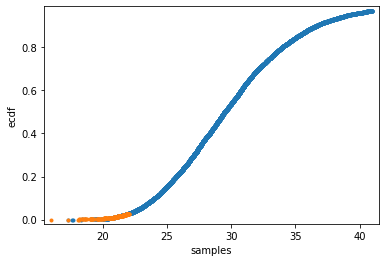

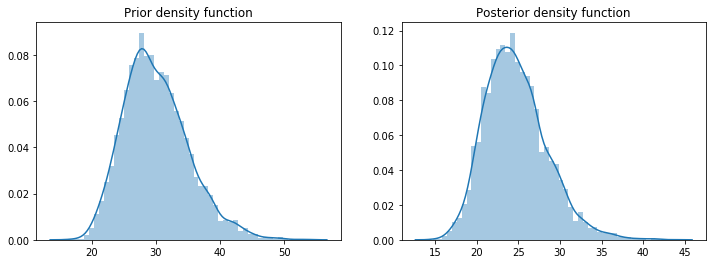

In [3]:
import seaborn as sns 
import tensorflow as tf
import tensorflow_probability as tfp


height_mean = 180
alpha = 38
beta = 1110

########## point 1 ##########

# To verify that the parameters of the inverse-gamma distribution lead to a prior
# probability of approximately 95% that sigma^2 in [22,41], it's enough compute
# the probability that P(22 <= sigma^2 <= 41).

inv_gamma = dist.InverseGamma(alpha, beta)
inv_gamma_cdf = ecdf(inv_gamma, torch.tensor(41))  - ecdf(inv_gamma, torch.tensor(22))

print("P(22 <= sigma^2 <= 41) = ", inv_gamma_cdf)

'''
Another possible way to perform the task, we will call W2:

tfd = tfp.distributions
dist = tfd.InverseGamma(concentration = alpha, scale = beta)

inv_gamma_cdf = dist.cdf(41) - dist.cdf(22)

tf.print("P(22 <= sigma^2 <= 41) = ", inv_gamma_cdf)
'''

########## point 2 ##########

# Note that if posterior distribution P(theta|X) belongs to the same family as
# the prior distribution P(theta),then the prior is said to be a conjugate prior
# for the likelihood function P(X|theta).
# It means that the posterior density of sigma^2 is a InvGamma distribution, so
# let's compute their parameters: alpha and beta.

x = [183, 172, 181, 170, 176, 180, 187, 176, 171, 190, 184, 173, 176, 179, 181, 186]

posterior_alpha = alpha + (len(x) / 2)
posterior_beta = 0

for i in x:
    posterior_beta = posterior_beta * (i - height_mean)**2

posterior_beta = beta + posterior_beta/2

# posterior distribution of sigma^2
'''
WAY2: 
posterior_distribution = tfd.InverseGamma(concentration = posterior_alpha, scale = posterior_beta)
'''

posterior_distribution = dist.InverseGamma(posterior_alpha, posterior_beta)

# generate samples
'''
WAY2: 
prior_samples = dist.sample(sample_shape = 5000)
posterior_samples = posterior_distribution.sample(sample_shape = 5000)
'''

prior_samples = [pyro.sample("invgamma_prior", inv_gamma) for i in range(5000)]
posterior_samples = [pyro.sample("invgamma_posterior", posterior_distribution) for i in range(5000)]

# plot
fig, axes = plt.subplots(1, 2, figsize=(12,4))
sns.distplot(prior_samples, ax=axes[0])
sns.distplot(posterior_samples, ax=axes[1])
axes[0].set_title('Prior density function')
axes[1].set_title('Posterior density function')
plt.show()

In [ ]:
########## point 3 ##########

From the hypothesis we know that $X = \sigma^2$ ~ $InvGamma(\alpha, \beta)$, if we define the standard
deviation as $\sigma = Y = \sqrt{X}$, we can compute its pdf and cdf by using the Transformation Theorem for random variable.

$F_{Y}(y) = P(\sqrt{X} \leq y) = P(X \leq y^{2}) = \int_{-\infty}^{y^{2}} \frac{\beta^{2}}{\Gamma(\alpha)} \cdot x^{-(1 + \alpha)} \cdot e^{-\frac{\beta}{x}} \space dx$


$f_{Y}(y) = \frac{d F_{Y}(y)}{dy} = 2 \cdot \frac{\beta^{2}}{\Gamma(\alpha)} \cdot y^{- (1 + 2 \cdot \alpha)} \cdot e^{- \frac{\beta}{y^2}}$

Where we apply the Fundamental theorem of calculus to compute the density function.

# Exercise 4

Prove that the Gamma distribution is the conjugate prior distribution for the Exponential likelihood.

- let be the prior defined as $P(\lambda) = Beta(\alpha, \beta)$;
- let be the likelihood defined as $P(X|\lambda) = Exp(\lambda)$;
- let be $P(x)$ the evidence.

So, we can analitically compute the conjugate prior distribution as follow:

$P(\lambda | X) = \frac{P(X | \lambda) \cdot P(\lambda)}{P(X)} \propto $
$\lambda \cdot e^{- \lambda \cdot x} \cdot \lambda^{\alpha - 1} \cdot e^{- \beta \cdot \lambda} \propto$
$\lambda^{(\alpha + 1) - 1} \cdot e^{- (\beta + x)\cdot \lambda} \space$ ~ $\space Beta(\alpha + 1, \beta + x)$

Where we have not compute the normalization constant because we are just interesting to a distribution direct proportional with the posterior probability.